# Collaboration and Competition

---

In this notebook, we learn how to solve the Unity ML-Agents tennis environment.  

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ddpg_agent import Agent
import matplotlib.pyplot as plt
import torch

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`


In [2]:
env = UnityEnvironment(file_name="local_test/Tennis_Windows_x86_64/Tennis.exe", seed=0, worker_id=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Now Train the smart agents with DDPG algorithm

Deep Deterministic Policy Gradient(DDPG) RL algorithm is introduced by deep mind, [paper ref](https://arxiv.org/abs/1509.02971). DDPG adapts the Deep Q-Learning (DQN) to the continuous action domain with Actor-Critic methods. Actor or critic each has two neteworks like DQN: target and regular.
The actor directly maps states to actions, and critic utilizes the best action from actor to calculate the next-state Q value. Then we minimize the mean-squared loss between the updated Q value and the original Q value like DQN. The actor's objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. The target network weight is updated with so-called soft update by slowly mixing the target and regular networks to target network weight. Exploration is done via adding noise to the action itself. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output.

#### Hyperparameter tuning Performed:
* with max_t=1000/3000 environment solved in 1768/2313 episodes! 
* with nn hidden layer 512,256, score is 0.17 @2300 episodes! Keep 256,128 one.
* soft update TAU = 1e-2/1e-3, enviorment solved in 1607/1768 episodes.    



Episode 1400	Averag Score: 0.49
Environment solved in 1401 episodes!	Average Score: 0.50


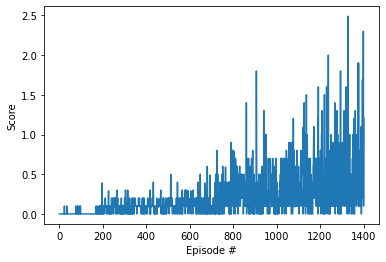

In [6]:
agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=0)
def ddpg(n_episodes=3000, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_mean = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment  
        states = env_info.vector_observations         # get the current state (for each agent)
        scores = np.zeros(num_agents)
        agent.reset()

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.max(scores))
        scores_mean.append(np.max(scores))

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverag Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores_mean

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

From above plot of rewards per episode, we see that the rewards converge after around 1400 episodes and the agent is able to receive an average reward of >0.5. 

In [7]:
env.close()

### 5. Ideas for Future Work
This can be served as a baseline for any future project with multi-agent enviroment. We can try other algorithms like [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf), and [D4PG](https://openreview.net/pdf?id=SyZipzbCb). 
This DDPG hyperparameter can be further tuned with number of updates per time step.